<img src="https://certificate.tpq.io/taim_logo.png" width="350px" align="right">

# Artificial Intelligence in Finance

## Vectorized Backtesting

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

In [1]:
import os
import math
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

## Backtesting an SMA-Based Strategy

In [2]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [3]:
symbol = 'EUR='

In [4]:
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                                parse_dates=True).dropna()[symbol])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [6]:
data['SMA1'] = data[symbol].rolling(42).mean()

In [7]:
data['SMA2'] = data[symbol].rolling(258).mean()

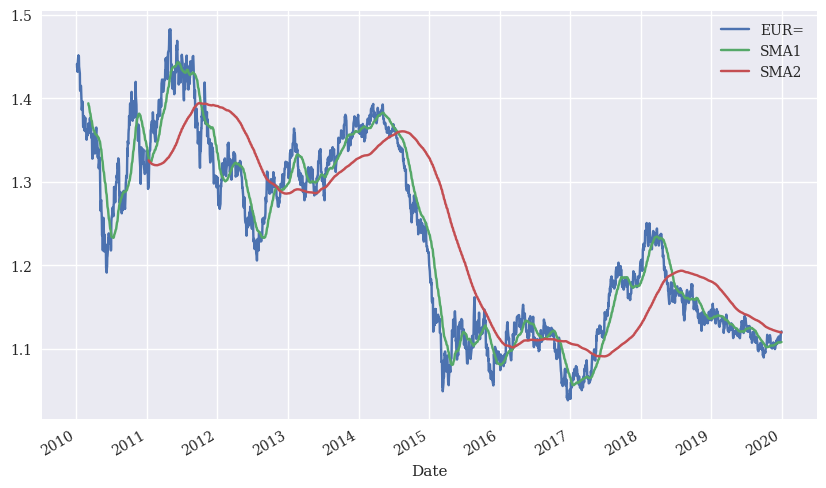

In [8]:
data.plot(figsize=(10, 6));

In [9]:
data.dropna(inplace=True)

In [10]:
data['p'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [11]:
data['p'] = data['p'].shift(1)

In [12]:
data.dropna(inplace=True)

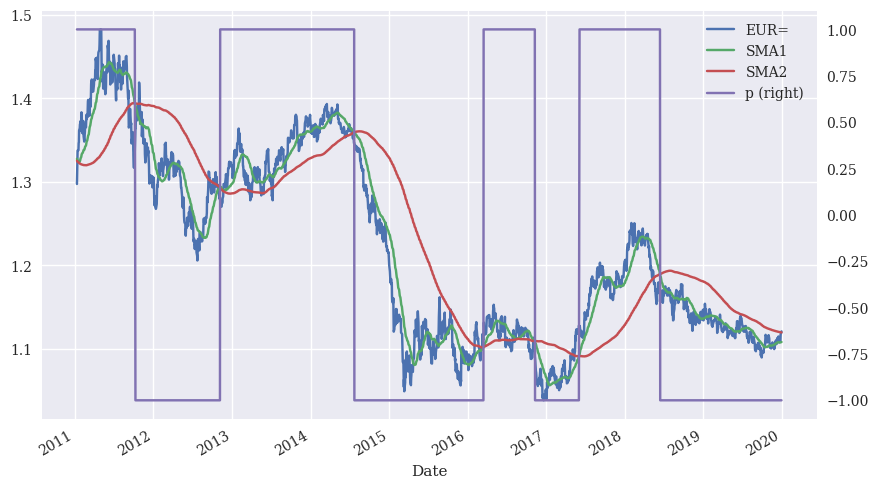

In [13]:
data.plot(figsize=(10, 6), secondary_y='p');

In [14]:
data['r'] = np.log(data[symbol] / data[symbol].shift(1))

In [15]:
data.dropna(inplace=True)

In [16]:
data['s'] = data['p'] * data['r']

In [17]:
data[['r', 's']].sum().apply(np.exp)  # gross performance

r   0.8640
s   1.3773
dtype: float64

In [18]:
data[['r', 's']].sum().apply(np.exp) - 1  # net performance

r   -0.1360
s    0.3773
dtype: float64

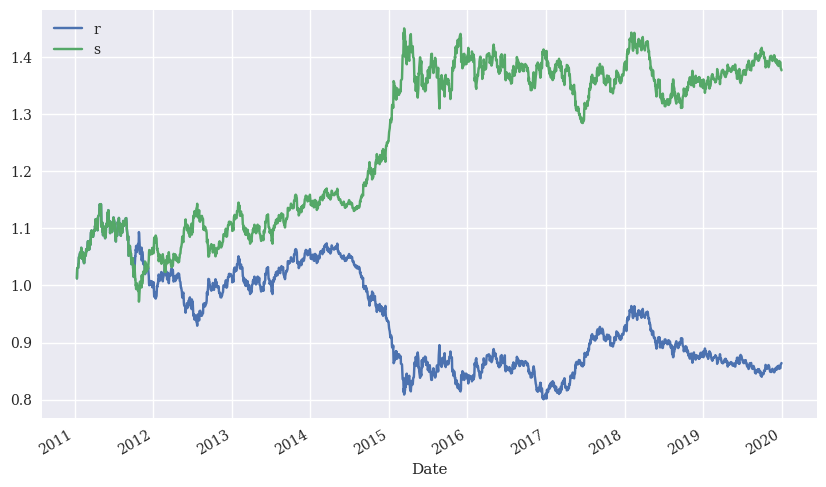

In [19]:
data[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [20]:
sum(data['p'].diff() != 0) + 1

9

In [21]:
pc = 0.005

In [22]:
data['s_'] = np.where(data['p'].diff() != 0,
                      data['s'] - pc, data['s'])

In [23]:
# data['s_'].iloc[0] -= pc

In [24]:
data['s_'].iloc[-1] -= pc

In [25]:
data[['r', 's', 's_']][data['p'].diff() != 0]

,r,s,s_
Date,,,
2011-01-12,0.0123,0.0123,0.0073
2011-10-10,0.0198,-0.0198,-0.0248
2012-11-07,-0.0034,-0.0034,-0.0084
2014-07-24,-0.0001,0.0001,-0.0049
2016-03-16,0.0102,0.0102,0.0052
2016-11-10,-0.0018,0.0018,-0.0032
2017-06-05,-0.0025,-0.0025,-0.0075
2018-06-15,0.0035,-0.0035,-0.0085


In [26]:
data[['r', 's', 's_']].sum().apply(np.exp)

r    0.8640
s    1.3773
s_   1.3167
dtype: float64

In [27]:
data[['r', 's', 's_']].sum().apply(np.exp) - 1

r    -0.1360
s     0.3773
s_    0.3167
dtype: float64

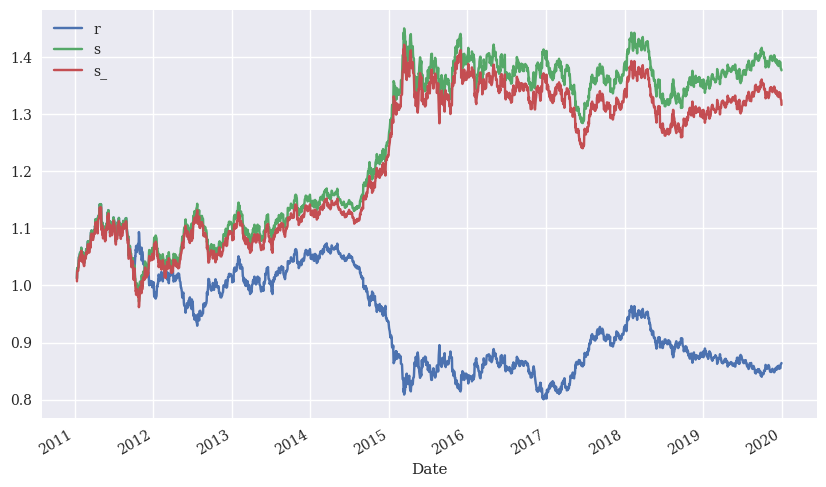

In [28]:
data[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [29]:
data[['r', 's', 's_']].std()

r    0.0054
s    0.0054
s_   0.0054
dtype: float64

In [30]:
data[['r', 's', 's_']].std() * math.sqrt(252)

r    0.0853
s    0.0853
s_   0.0855
dtype: float64

## Backtesting a Daily DNN-Based Strategy

In [31]:
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                                parse_dates=True).dropna()[symbol])

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [33]:
lags = 5

In [34]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift(1))
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [35]:
data, cols = add_lags(data, symbol, lags, window=20)

In [36]:
import random
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.metrics import accuracy_score

In [37]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

In [38]:
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.0001)

In [39]:
def create_model(hl=2, hu=128, dropout=False, rate=0.3,
                regularize=False, reg=l1(0.0005),
                optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                 activity_regularizer=reg,  
                 activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                     activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [40]:
split = '2018-01-01'

In [41]:
train = data.loc[:split].copy()

In [42]:
np.bincount(train['d'])

array([ 982, 1006])

In [43]:
mu, std = train.mean(), train.std()

In [44]:
train_ = (train - mu) / std

In [45]:
set_seeds()
model = create_model(hl=2, hu=64)

In [46]:
%%time 
model.fit(train_[cols], train['d'],
        epochs=20, verbose=False,
        validation_split=0.2, shuffle=False)

CPU times: user 1.29 s, sys: 341 ms, total: 1.63 s
Wall time: 1.18 s


In [47]:
model.evaluate(train_[cols], train['d'])

63/63 [==============================] - 0s 406us/step - loss: 0.6748 - accuracy: 0.5951


[0.6748248338699341, 0.5950704216957092]

In [48]:
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, 0)

63/63 [==============================] - 0s 358us/step


In [49]:
train['p'] = np.where(train['p'] == 1, 1, -1)

In [50]:
train['p'].value_counts()

p
-1    1125
 1     863
Name: count, dtype: int64

In [51]:
train['s'] = train['p'] * train['r']

In [52]:
train[['r', 's']].sum().apply(np.exp)

r   0.8787
s   5.3770
dtype: float64

In [53]:
train[['r', 's']].sum().apply(np.exp)  - 1

r   -0.1213
s    4.3770
dtype: float64

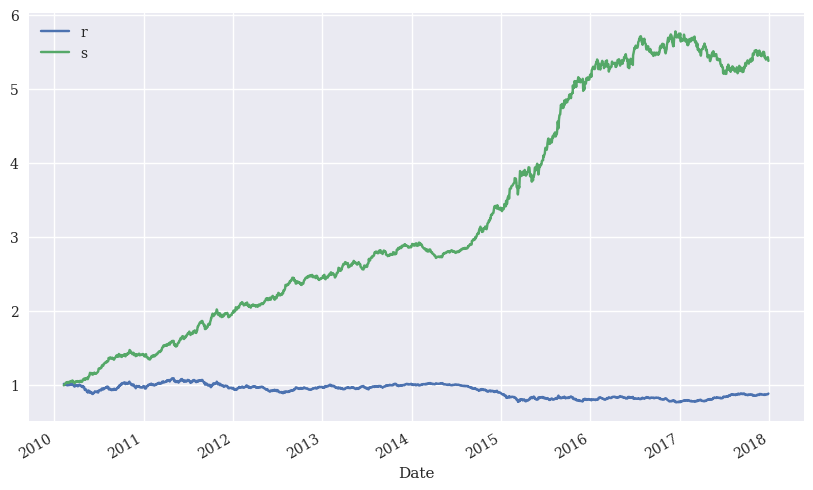

In [54]:
train[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [55]:
test = data.loc[split:].copy()

In [56]:
test_ = (test - mu) / std

In [57]:
model.evaluate(test_[cols], test['d'])

16/16 [==============================] - 0s 526us/step - loss: 0.6953 - accuracy: 0.5149


[0.6952627301216125, 0.5149105191230774]

In [58]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)

16/16 [==============================] - 0s 665us/step


In [59]:
test['p'].value_counts()

p
-1    417
 1     86
Name: count, dtype: int64

In [60]:
test['s'] = test['p'] * test['r']

In [61]:
test[['r', 's']].sum().apply(np.exp)

r   0.9345
s   1.0472
dtype: float64

In [62]:
test[['r', 's']].sum().apply(np.exp) - 1

r   -0.0655
s    0.0472
dtype: float64

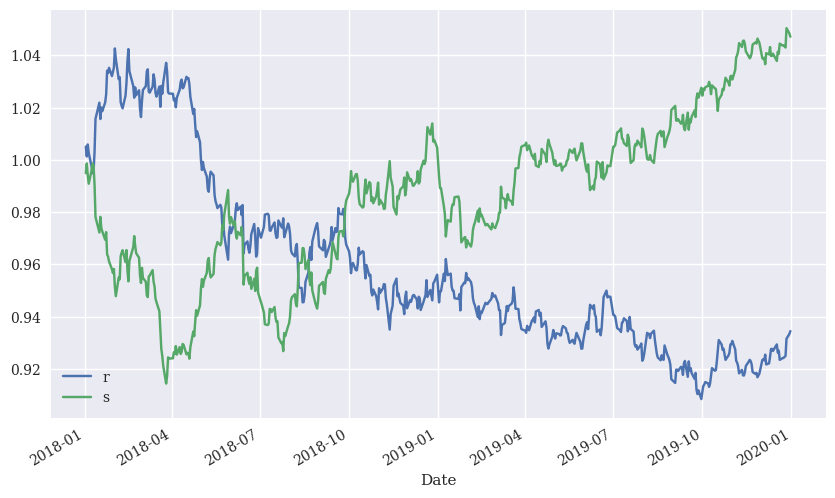

In [63]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [64]:
sum(test['p'].diff() != 0) + 1

138

In [65]:
spread = 0.00012
pc = spread / data[symbol].mean()
print(f'{pc:.6f}')

0.000098


In [66]:
test['s_'] = np.where(test['p'].diff() != 0,
                      test['s'] - pc, test['s'])

In [67]:
# test['s_'].iloc[0] -= pc

In [68]:
test['s_'].iloc[-1] -= pc

In [69]:
test[['r', 's', 's_']].sum().apply(np.exp)

r    0.9345
s    1.0472
s_   1.0332
dtype: float64

In [70]:
test[['r', 's', 's_']].sum().apply(np.exp) - 1

r    -0.0655
s     0.0472
s_    0.0332
dtype: float64

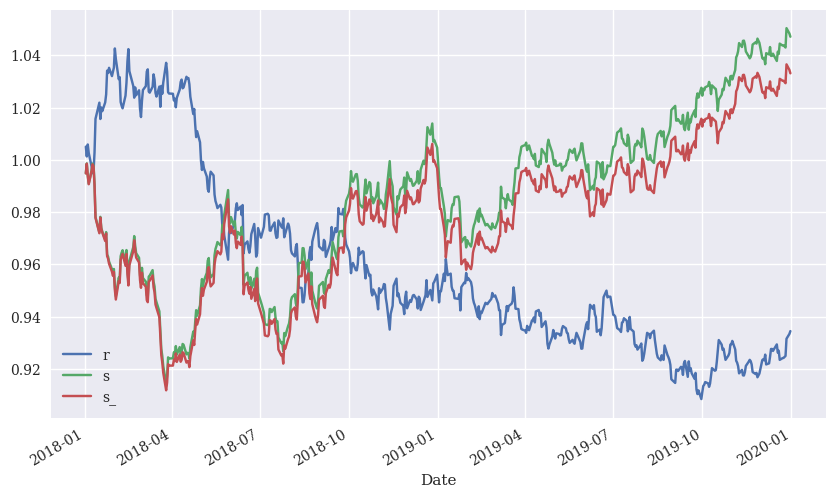

In [71]:
test[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Backtesting an Intraday DNN-Based Strategy

In [72]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'

In [73]:
symbol = 'EUR='

In [74]:
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                    parse_dates=True).dropna()['CLOSE'])
data.columns = [symbol]

In [75]:
data = data.resample('5min', label='right').last().ffill()

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26486 entries, 2019-10-01 00:05:00 to 2019-12-31 23:10:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    26486 non-null  float64
dtypes: float64(1)
memory usage: 413.8 KB


In [77]:
data.head()

,EUR=
Date,
2019-10-01 00:05:00,1.0898
2019-10-01 00:10:00,1.0899
2019-10-01 00:15:00,1.0899
2019-10-01 00:20:00,1.0899
2019-10-01 00:25:00,1.0898


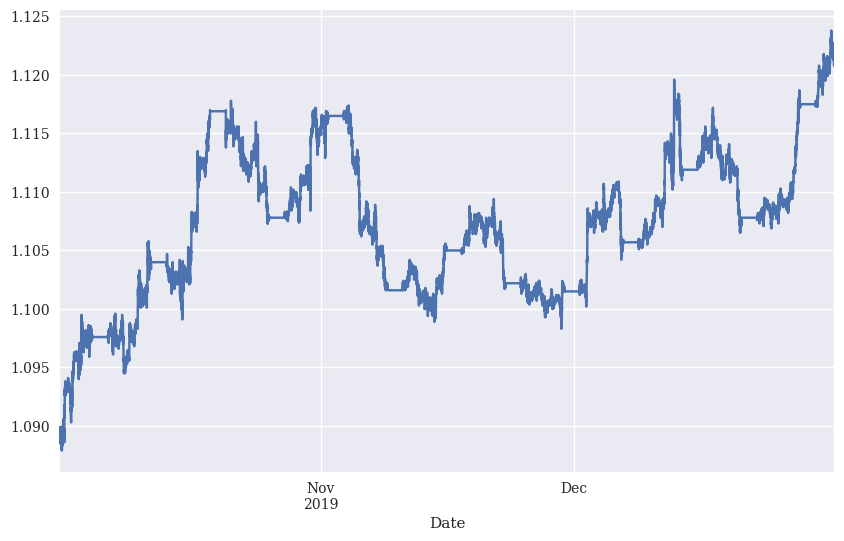

In [78]:
data[symbol].plot(figsize=(10, 6));

In [79]:
lags = 5

In [80]:
data, cols = add_lags(data, symbol, lags, window=20)

In [81]:
split = int(len(data) * 0.85)

In [82]:
train = data.iloc[:split].copy()

In [83]:
np.bincount(train['d'])

array([16284,  6207])

In [84]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [85]:
mu, std = train.mean(), train.std()

In [86]:
train_ = (train - mu) / std

In [87]:
set_seeds()
model = create_model(hl=1, hu=128,
                     reg=True, dropout=False)

In [88]:
%%time 
model.fit(train_[cols], train['d'],
          epochs=40, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 17.5 s, sys: 4.8 s, total: 22.3 s
Wall time: 15 s


In [89]:
model.evaluate(train_[cols], train['d'])

703/703 [==============================] - 0s 344us/step - loss: 0.5258 - accuracy: 0.6692


[0.5257923007011414, 0.6692010164260864]

In [90]:
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, -1)

703/703 [==============================] - 0s 312us/step


In [91]:
train['p'].value_counts()

p
 1    11303
-1    11188
Name: count, dtype: int64

In [92]:
train['s'] = train['p'] * train['r']

In [93]:
train[['r', 's']].sum().apply(np.exp)

r   1.0223
s   1.6716
dtype: float64

In [94]:
train[['r', 's']].sum().apply(np.exp) - 1

r   0.0223
s   0.6716
dtype: float64

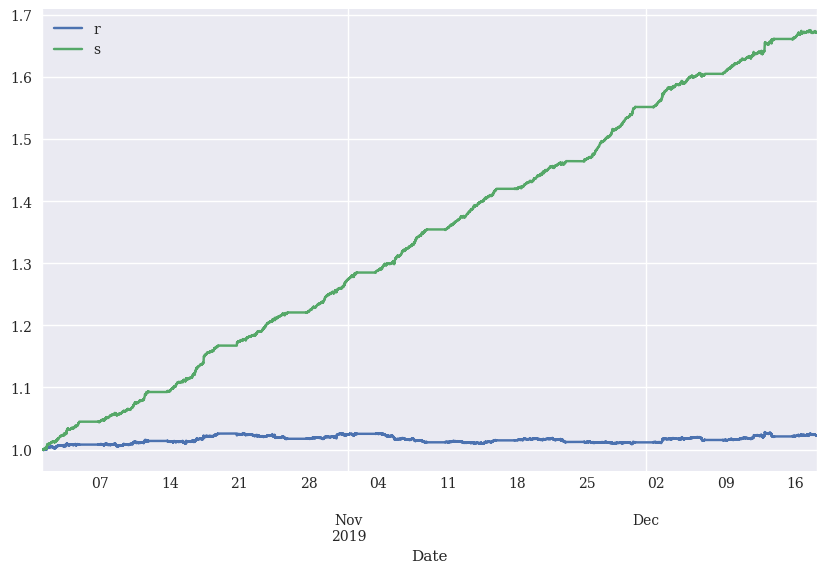

In [95]:
train[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [96]:
test = data.iloc[split:].copy()

In [97]:
test_ = (test - mu) / std

In [98]:
model.evaluate(test_[cols], test['d'])

125/125 [==============================] - 0s 392us/step - loss: 0.5345 - accuracy: 0.6569


[0.534525990486145, 0.6569269299507141]

In [99]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)

125/125 [==============================] - 0s 321us/step


In [100]:
test['p'].value_counts()

p
-1    2043
 1    1927
Name: count, dtype: int64

In [101]:
test['s'] = test['p'] * test['r']

In [102]:
test[['r', 's']].sum().apply(np.exp)

r   1.0071
s   1.0688
dtype: float64

In [103]:
test[['r', 's']].sum().apply(np.exp) - 1

r   0.0071
s   0.0688
dtype: float64

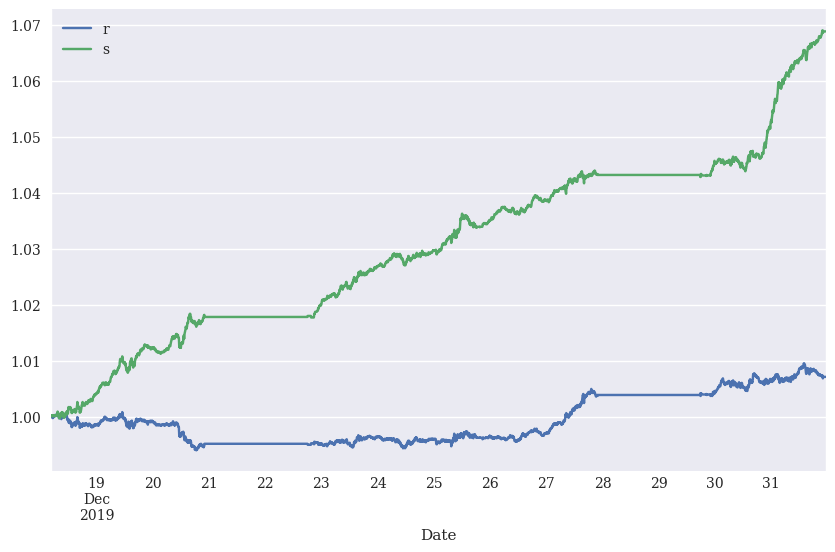

In [104]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [105]:
sum(test['p'].diff() != 0) + 1

1212

In [106]:
spread = 0.00012
pc_1 = spread / test[symbol]

In [107]:
spread = 0.00006
pc_2 = spread / test[symbol]

In [108]:
test['s_1'] = np.where(test['p'].diff() != 0,
                       test['s'] - pc_1, test['s'])

In [109]:
# test['s_1'].iloc[0] -= pc_1.iloc[0]
test['s_1'].iloc[-1] -= pc_1.iloc[0]

In [110]:
test['s_2'] = np.where(test['p'].diff() != 0,
                       test['s'] - pc_2, test['s'])

In [111]:
# test['s_2'].iloc[0] -= pc_2.iloc[0]
test['s_2'].iloc[-1] -= pc_2.iloc[0]

In [112]:
test[['r', 's', 's_1', 's_2']].sum().apply(np.exp)

r     1.0071
s     1.0688
s_1   0.9378
s_2   1.0011
dtype: float64

In [113]:
test[['r', 's', 's_1', 's_2']].sum().apply(np.exp) - 1

r      0.0071
s      0.0688
s_1   -0.0622
s_2    0.0011
dtype: float64

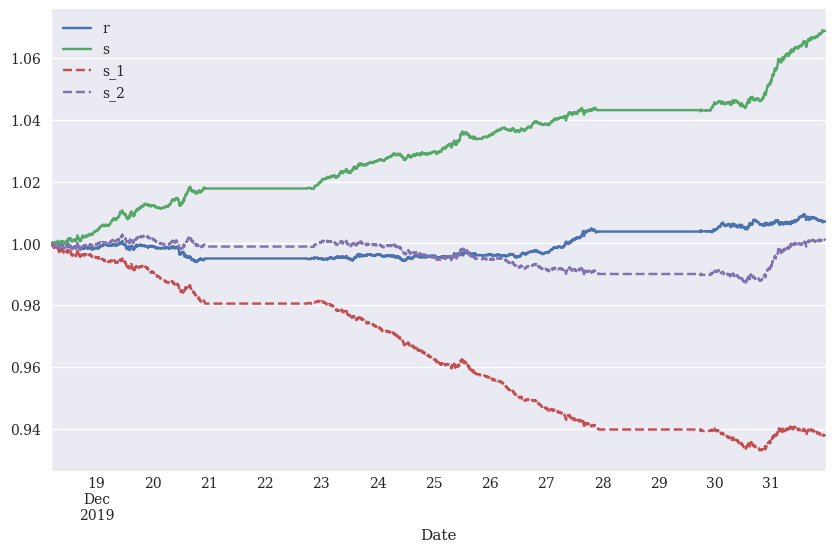

In [114]:
test[['r', 's', 's_1', 's_2']].cumsum().apply(
    np.exp).plot(figsize=(10, 6), style=['-', '-', '--', '--']);

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>